<a href="https://colab.research.google.com/github/Rin-niee/MachineLearning/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 6. Обучение без учителя

## **Цель занятия:**
Изучить методы обучения без учителя, познакомиться с алгоритмами кластеризации, понять их применение и реализовать модели кластеризации с использованием различных алгоритмов.

## **Задание состоит из следующих частей:**
1. Определение обучения без учителя
2. Разбор алгоритмов DBSSCAN, K-means
3. Метрики качества кластеризации
4. Пример полезных задач, которые решает кластеризация

**P.S.** Некоторые вещи (например PCA, обработка текстовых данных) мы пройдем чуть позже.

## Задачи⏰

1. Преобразовать датасет
2. Построить кластеры
3. Описать результат полученных кластеров (для K-Means и DBSSCAN)
4. Объяснить метрики качества

## Предобработка


In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/heart.csv')

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   AGE_50     200 non-null    int64
 1   MD_50      200 non-null    int64
 2   SBP_50     200 non-null    int64
 3   DBP_50     200 non-null    int64
 4   HT_50      200 non-null    int64
 5   WT_50      200 non-null    int64
 6   CHOL_50    200 non-null    int64
 7   SES        200 non-null    int64
 8   CL_STATUS  200 non-null    int64
 9   MD_62      200 non-null    int64
 10  SBP_62     200 non-null    int64
 11  DBP_62     200 non-null    int64
 12  CHOL_62    200 non-null    int64
 13  WT_62      200 non-null    int64
 14  IHD_DX     200 non-null    int64
 15  DEATH      200 non-null    int64
dtypes: int64(16)
memory usage: 25.1 KB


### Преобразование категориальных фич

In [209]:
df[['MD_50', 'SES', 'CL_STATUS', 'MD_62', 'IHD_DX', 'DEATH']] = df[['MD_50', 'SES', 'CL_STATUS', 'MD_62', 'IHD_DX', 'DEATH']].astype({'MD_50':'category', 'SES':'category', 'CL_STATUS':'category', 'MD_62':'category', 'IHD_DX':'category', 'DEATH':'category'})
#в моем случае категориальные переменные нужно выделить отдельно и изменить тип данных
category_columns: list[str] = df.select_dtypes(include=['category']).columns # собираем колонки помеченные как category


# Применяем One-Hot Encoding
df = pd.get_dummies(df, columns=category_columns, drop_first=True)
df = df.astype({col: float for col in df.select_dtypes(include=[int]).columns}) #а эти изменим в float, чтобы не было проблем с последующим выделением непрерывных признаков

df = df.astype({col: int for col in df.select_dtypes(include=[bool]).columns}) #так как колонок категориальных слишком много, просто делаем все булевые значения интовыми


In [166]:
df

,AGE_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SBP_62,DBP_62,CHOL_62,WT_62,...,IHD_DX_1,IHD_DX_2,IHD_DX_3,IHD_DX_4,IHD_DX_5,IHD_DX_6,IHD_DX_7,IHD_DX_8,IHD_DX_9,DEATH_1
0,42.0,110.0,65.0,64.0,147.0,291.0,120.0,78.0,271.0,146.0,...,0,1,0,0,0,0,0,0,0,1
1,53.0,130.0,72.0,69.0,167.0,278.0,122.0,68.0,250.0,165.0,...,0,0,0,0,0,0,0,0,1,1
2,53.0,120.0,90.0,70.0,222.0,342.0,132.0,90.0,304.0,223.0,...,0,1,0,0,0,0,0,0,0,1
3,48.0,120.0,80.0,72.0,229.0,239.0,118.0,68.0,209.0,227.0,...,0,0,1,0,0,0,0,0,0,1
4,53.0,118.0,74.0,66.0,134.0,243.0,118.0,56.0,261.0,138.0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50.0,115.0,80.0,66.0,148.0,300.0,115.0,65.0,273.0,152.0,...,0,0,0,0,0,0,0,0,0,0
196,23.0,110.0,70.0,69.0,137.0,120.0,112.0,76.0,198.0,153.0,...,0,0,0,0,0,0,0,0,0,0
197,20.0,130.0,80.0,66.0,150.0,210.0,130.0,85.0,274.0,158.0,...,0,0,0,0,0,0,0,0,0,0
198,46.0,140.0,84.0,66.0,138.0,130.0,148.0,88.0,160.0,157.0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE_50       200 non-null    float64
 1   SBP_50       200 non-null    float64
 2   DBP_50       200 non-null    float64
 3   HT_50        200 non-null    float64
 4   WT_50        200 non-null    float64
 5   CHOL_50      200 non-null    float64
 6   SBP_62       200 non-null    float64
 7   DBP_62       200 non-null    float64
 8   CHOL_62      200 non-null    float64
 9   WT_62        200 non-null    float64
 10  MD_50_2      200 non-null    int64  
 11  MD_50_3      200 non-null    int64  
 12  MD_50_4      200 non-null    int64  
 13  SES_2        200 non-null    int64  
 14  SES_3        200 non-null    int64  
 15  SES_4        200 non-null    int64  
 16  SES_5        200 non-null    int64  
 17  CL_STATUS_3  200 non-null    int64  
 18  CL_STATUS_4  200 non-null    int64  
 19  CL_STATU

### Преобразование непрерывных фич

In [210]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [169]:
df

,AGE_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SBP_62,DBP_62,CHOL_62,WT_62,...,IHD_DX_1,IHD_DX_2,IHD_DX_3,IHD_DX_4,IHD_DX_5,IHD_DX_6,IHD_DX_7,IHD_DX_8,IHD_DX_9,DEATH_1
0,0.448980,0.180328,0.264706,0.214286,0.279412,0.412048,0.31250,0.318841,0.576419,0.275362,...,0,1,0,0,0,0,0,0,0,1
1,0.673469,0.344262,0.333333,0.571429,0.426471,0.380723,0.32500,0.173913,0.484716,0.413043,...,0,0,0,0,0,0,0,0,1,1
2,0.673469,0.262295,0.509804,0.642857,0.830882,0.534940,0.38750,0.492754,0.720524,0.833333,...,0,1,0,0,0,0,0,0,0,1
3,0.571429,0.262295,0.411765,0.785714,0.882353,0.286747,0.30000,0.173913,0.305677,0.862319,...,0,0,1,0,0,0,0,0,0,1
4,0.673469,0.245902,0.352941,0.357143,0.183824,0.296386,0.30000,0.000000,0.532751,0.217391,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.612245,0.221311,0.411765,0.357143,0.286765,0.433735,0.28125,0.130435,0.585153,0.318841,...,0,0,0,0,0,0,0,0,0,0
196,0.061224,0.180328,0.313725,0.571429,0.205882,0.000000,0.26250,0.289855,0.257642,0.326087,...,0,0,0,0,0,0,0,0,0,0
197,0.000000,0.344262,0.411765,0.357143,0.301471,0.216867,0.37500,0.420290,0.589520,0.362319,...,0,0,0,0,0,0,0,0,0,0
198,0.530612,0.426230,0.450980,0.357143,0.213235,0.024096,0.48750,0.463768,0.091703,0.355072,...,0,0,0,0,0,0,0,0,0,0


## K-means

**K-means** — это алгоритм кластеризации, который делит данные на 𝑘 групп (кластеров). Основная идея: найти центры кластеров так, чтобы точки внутри одного кластера были ближе друг к другу, чем к точкам из других кластеров.

1. Инициализация: выбираем 𝑘 случайных центров (центроидов).
2. Присвоение точек: каждая точка относится к ближайшему центру.
Обновление центров: пересчитываем центры кластеров как среднее всех точек в кластере.
3. Повторяем шаги 2–3, пока центры не перестанут меняться или не достигнем максимального числа итераций.

In [88]:
! pip install ipywidgets


In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):

    # преобразуем X в numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        np.random.seed(42)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for step in range(max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            plot_kmeans_iteration(X, centroids, labels, step)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids

    def run_kmeans(k, max_iters):
        k_means_interactive(X, k, max_iters)

    k_slider = widgets.IntSlider(value=3, min=2, max=max_clusters, step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

# Берем датасет и визуализируем K-means
interactive_kmeans_visualization(df[:100])


interactive(children=(IntSlider(value=3, description='Clusters (k):', max=10, min=2), IntSlider(value=10, desc…

Здесь можно отметить, что при существовании трех центров признаки распределены довольно неоднозначно и близко друг к другу, основные кластеры угадываются с трудом, так, например, центр слева отвечает за бирюзовый кластер, тот, что в центре - за желтый и правый за фиолетовый(если разбивать по 3, с двумя все выглядит довольно четко)

### K-means через реализацию skelarn

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 3  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = df.copy()
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(df, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")


Статистика по кластерам:

Статистика для признака 'AGE_50':
             mean       std       min       max
Cluster                                        
0        0.659439  0.202125  0.102041  1.000000
1        0.484994  0.208336  0.000000  0.897959
2        0.458884  0.199070  0.061224  0.897959

Статистика для признака 'SBP_50':
             mean       std       min       max
Cluster                                        
0        0.325948  0.155931  0.098361  0.918033
1        0.327025  0.169901  0.000000  1.000000
2        0.250964  0.099647  0.057377  0.524590

Статистика для признака 'DBP_50':
             mean       std       min       max
Cluster                                        
0        0.443934  0.115414  0.264706  1.000000
1        0.472751  0.104304  0.215686  0.705882
2        0.417964  0.098067  0.000000  0.656863

Статистика для признака 'HT_50':
             mean       std       min       max
Cluster                                        
0        0.498884  0

#### **Анализ кластеров**

При разбиении на три кластера на 3 части мы получаем следующее:
1. Определенно и точно к кластеру 0 принадлежит смерть (DEATH), т.к mean составляет 1.0, в то время как в кластерах 1 и 2 смертность нулевая
2. CL_STATUS_8 принадлежит к кластеру 2 (0.926471) и 1(0.764706), а также 3 (0.926471) что говорит о его близости сразу к трем классам, в то время как другие клинические статусы имеют сравнительно малые показатели
Кластер 2 является самым разобщенным, потому большого отношения ни один из признаков к нему не имеет.
3. AGE_ 50 относится к классу 0 в большей степени, но также имеет принадлежность к другим классам в меньшей мере, что может говорить н наличии людей старше 50 лет сразу в трех кластерах
Коэффициент силуэта - 0.0993, что говорит о высоком перессечении кластеров и слабом разделении между ними. И , действительно, многие объекты или не связаны друг с другом или имеют отношение ко многим в общей значимости (это можно увидеть и на рисунке, но при том из всех протестированных результатов, полученнный выше - самый приемлемый)

### DBSSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации, основанный на плотности точек в пространстве.

Параметры алгоритма:

- **Epsilon (eps)**: радиус окрестности точки.
- **Min_samples**: минимальное количество точек в eps-окрестности для того, чтобы точка считалась ядром кластера.

Классификация точек:

- **Core point (ядро)**: если в eps-окрестности точки находится не менее min_samples точек, то она является ядром.
- **Border point (граничная точка)**: точка, которая находится в eps-окрестности ядра, но сама не является ядром.
- **Noise point (шум)**: точка, которая не является ни ядром, ни граничной точкой. (**входит в кластер -1**)

Точки, которые связаны по плотности (через ядра и их eps-окрестности), объединяются в один кластер.

# Изменения в датафрейме
т.к данные, которые были в исходном фрейме обращались шумом и взаимосвязь не находилось, было принято решение переработать изначальный датафрейм и оформить получившийся результат в работу
т.к DEATH не имела связи, была введена дополнительная переменная risk_group аналогично с предыдущими работами, а также дропнуты некоторые данные(дублирующиеся с изначальными и вводящими в излишнюю путаницу)

In [203]:
df = pd.read_csv('/content/heart.csv')
#в моем случае категориальные переменные нужно выделить отдельно и изменить тип данных
df['risk_group']= np.where(df['IHD_DX']<=5, 1, 0)
df.risk_group = df.risk_group.astype('category')
category_columns: list[str] = df.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
df = pd.get_dummies(df, columns=category_columns, drop_first=True)

df = df.drop('IHD_DX', axis=1) #дроп перввоначальной переменной, на основе которой строилась новая
df = df.drop('MD_50', axis=1)
df = df.drop('SBP_50', axis=1)
df = df.drop('DBP_50', axis=1)
df = df.drop('CHOL_50', axis=1)
df = df.drop('WT_50', axis=1)
df = df.astype({col: float for col in df.select_dtypes(include=[int]).columns})
df.risk_group_1 = df.risk_group_1.astype(int)

from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df)


Output()

### DBSSCAN через sklearn

Количество кластеров: 2
Статистика по кластерам:

Статистика для признака 'AGE_50':
             mean       std       min       max  count
Cluster                                               
0        0.637998  0.206460  0.102041  1.000000     42
1        0.455995  0.191648  0.040816  0.897959     96

Статистика для признака 'HT_50':
             mean       std       min       max  count
Cluster                                               
0        0.515306  0.189006  0.071429  0.928571     42
1        0.535714  0.183064  0.142857  1.000000     96

Статистика для признака 'SES':
             mean       std   min   max  count
Cluster                                       
0        0.464286  0.130331  0.25  0.75     42
1        0.479167  0.228458  0.00  1.00     96

Статистика для признака 'CL_STATUS':
             mean       std   min  max  count
Cluster                                      
0        0.988095  0.046275  0.75  1.0     42
1        0.989583  0.043174  0.75  1.0     96


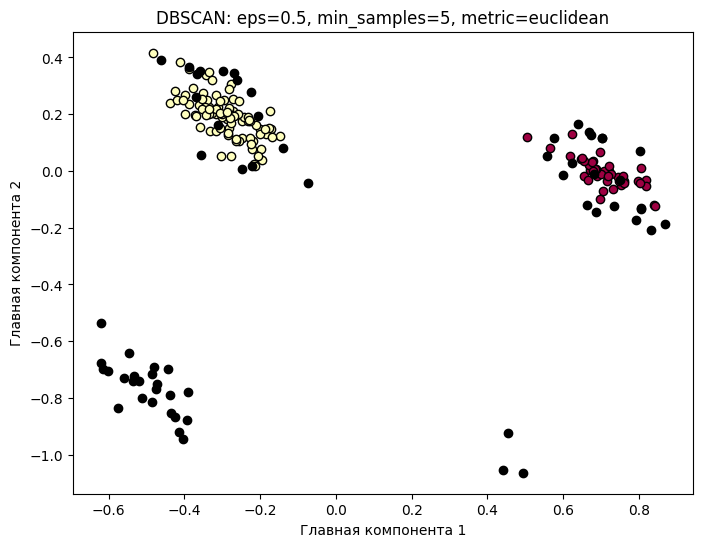

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 0.5
min_samples = 5
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(df)

# Добавляем метки кластеров в DataFrame
df_dbscan = df.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(df[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


#### **Анализ кластеров**

Некоторые различия в двух получившихся кластерах:
1. DEATH относится к кластеру 0 с mean = 1.0
2. AGE_50 в большей степени также относится к кластеру 0.
3. WT_62 в большей степени относится к кластеру 1.
остальные же относятся одинаково слабо или сильно
Коэффициент силуэта составит 0.3997
Вывод: наиболее влиятельное отношения разве что у смерти и возраста, остальные широко варьируются между двумя кластерами и сказать о распределенении переменных сложно

После применения алгоритма DBSCAN мы получили **два кластера**, между которыми наблюдаются существенные различия по некоторым признакам. Рассмотрим три наиболее значимых признака:

1. **Type_White (Тип вина):**
   - **Кластер 0** состоит исключительно из красных вин (значение `mean = 0.0`).
   - **Кластер 1** состоит исключительно из белых вин (значение `mean = 1.0`).

2. **Volatile Acidity:**
   - **Кластер 0** (красные вина) имеет более высокое среднее значение летучей кислотности (`mean ≈ 0.299`), чем **Кластер 1** (белые вина) со средним значением (`mean ≈ 0.132`).

3. **Total Sulfur Dioxide:**
   - **Кластер 1** (белые вина) имеет значительно более высокое среднее содержание общего диоксида серы (`mean ≈ 0.305`), в сравнении с **Кластером 0** (красные вина) со средним значением (`mean ≈ 0.093`).

**Коэффициент силуэта для DBSCAN:** 0.6136

**Общее заключение:**

Алгоритм DBSCAN успешно разделил вина на два кластера по типу (красное и белое), при этом выявив существенные различия в летучей кислотности и содержании диоксида серы между ними.

### Метрики качества кластеризации

**Дополнительные метрики для оценки качества кластеризации**

Кроме коэффициента силуэта, существуют и другие метрики, которые помогают оценить качество кластеризации. Вот некоторые из них:

1. **Индекс Калински-Харабаза (Calinski-Harabasz Index):**
   - **Описание:** Измеряет отношение между разбросом между кластерами и разбросом внутри кластеров.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к бесконечности больше, тем лучше раздленеие между кластерами

2. **Индекс Дэвиса-Болдина (Davies-Bouldin Index):**
   - **Описание:** Оценивает среднее "сходство" между каждым кластером и наиболее похожим на него другим кластером. Сходство основано на расстоянии между кластерами и их размером.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к 0, тем лучшее разделение между кластерами.

3. **Коэффициент силуэта (Silhouette Score):**

    - **Описание:** Измеряет, насколько объект похож на свой кластер по сравнению с другими кластерами.
    - **Диапазон значений:** От -1 до 1.
    - **Интерпретация:** Значения, близкие к 1, указывают на хорошую кластеризацию. Значения около 0 означают, что кластеры перекрываются. Отрицательные значения указывают на возможные ошибки в кластеризации.

In [213]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(df, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(df, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(df, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 20.6057
Индекс Дэвиса-Болдина для K-means: 2.5075
Коэффициент силуэта для K-means: 0.0993


In [207]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = df[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")


Индекс Калински-Харабаза для DBSCAN: 95.0912
Индекс Дэвиса-Болдина для DBSCAN: 1.0684
Коэффициент силуэта для DBSCAN: 0.3997


Общий вывод: индекс Калински-Харабаза для DBSCAN, что говорит о высоком разбросе между кластерами и их разделении. параметр намного выше нуля, но не в пределах больших чисел. В целом, в сравнении с K-means, где эти метрики намного ниже и кластеры очень явно пересекаются между собой ниже, демонстрируют хороший результат.
Расстояния между кластерами (Индекс Дэвиса-Болдина) при использовании двух методов  относительно небольшой, что говорит о неплохом разделении между кластерами
Коэффициент силуэта - кластеры, пусть и в малой степени, но имеют положительный результат, пусть и не очень хороший для звания хорошей кластеризации, в K-means он вовсе устремлен почти что к нулю
В общих чертах, кластеры разделены не очень хорошо, имеют много общих параметров, что говорит о недостаточном качестве получившихся результатов, пусть положительных. Возможно, вина в малой связи между признаками в исходном датафрейме.
